# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session A1.2: Basic Concepts II

This notebook will introduce additional GT4Py concepts, such as the execution model, stage extents and temporaries. We will also take a closer look at the different backends and performance.

In [1]:
# standard packages
from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["font.size"] = 12

# import GT4Py
import gt4py
from gt4py import gtscript
from gt4py.gtscript import Field, PARALLEL, computation, interval

# some useful tools used in this notebook (mostly plotting)
from tools import plot_two_ij_slices

## Execution model

The iteration domain in GT4Py is a 3-dimensional domain: `I` and `J` axes live on the horizontal spatial plane, and axis `K` represents the vertical spatial dimension. Computations on the horizontal plane are always executed in parallel and thus `I` and `J` are called parallel axes, while computations on `K` are executed sequentially or in parallel.

A `gtscript.stencil` is composed of one or more computation. Each computation defines an iteration policy (PARALLEL, FORWARD, BACKWARD) and isn, something itself composed of one or more non-overlapping vertical interval specifications, each one of them representing a vertical loop over the `K` axis with the iteration policy of the computation. Intervals are specified in their order of execution with each interval containing one or more statements. We will look into execution policies in the `K` axis more in the next session.

The effect of a GTScript stencil program is as if statements are executed as follows:
1. Computations are executed sequentially in the order they appear in the code,
2. Vertical intervals are executed sequentially in the order defined by the iteration policy of the computation
3. Every vertical interval is executed as a sequential for-loop over the K-range following the order defined by the iteration policy,
4. For every assignment inside the interval, first, the right hand side is evaluated in a parallel for-loop over the horizontal dimension(s), then, the resulting horizontal slice is assigned to the left hand side.
5. For if-else statements, the condition is evaluated first, then the if and else bodies are evaluated with the same rule as above. Some restrictions apply to offset reads, see Conditionals.

We will look into if-else conditionals in a later session. You can refer back to these rules during the workshop.

We start by setting up a parallel environment

In [2]:
%env OMP_PLACES=threads
%env OMP_PROC_BIND=true
%env OMP_NUM_THREADS=40

env: OMP_PLACES=threads
env: OMP_PROC_BIND=true
env: OMP_NUM_THREADS=40


In order to investigate what various backends do without investigating the code we look at the **illegal** shift stencil `a[0, 0, 0] = a[1, 0, 0]` in all four parallel horizontal dimensions. The result is not deterministic since each computation happens on every ij-level in parallel and we have a race condition here. The visualization of the results can give us insights into what happens nevertheless. For this session choose either `gtmc` or `gtx86` as the backend to look at

In [3]:
#backend = "gtx86"
backend = "gtmc"

In [4]:
@gtscript.stencil(backend=backend)
def shift_i_plus_one(a: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        a = a[1, 0, 0]
@gtscript.stencil(backend=backend)
def shift_i_minus_one(a: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        a = a[-1, 0, 0]
@gtscript.stencil(backend=backend)
def shift_j_plus_one(a: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        a = a[0, 1, 0]
@gtscript.stencil(backend=backend)
def shift_j_minus_one(a: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        a = a[0, -1, 0]

In [5]:
# domain setup
nhalo = 3
nx, ny, nz = 54, 54, 1

origin = (nhalo, nhalo, 0)
domain = (nx, ny, nz)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)

# storage creation
in_field = gt4py.storage.from_array(np.random.randn(shape[0], shape[1], shape[2]), backend, origin, shape, dtype=np.float64)
out_field_i = in_field.copy()
out_field_i_minus = in_field.copy()
out_field_j = in_field.copy()
out_field_j_minus = in_field.copy()

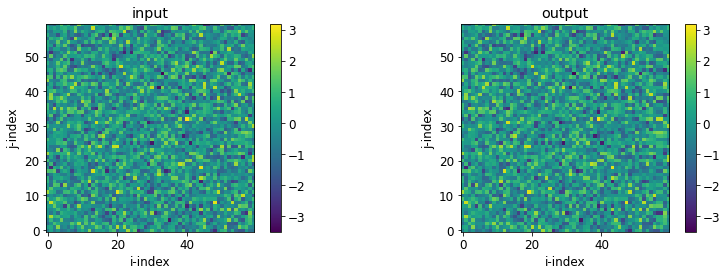

In [6]:
# run stencil i+1
shift_i_plus_one(a=out_field_i, origin=origin, domain=domain)
# visualize results
plot_two_ij_slices(in_field, out_field_i)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Is this the expected result?</li>
        <li style="margin-bottom: 10px"> Run the same experiment for the other three offsets.</li>
    </ol>
</div>

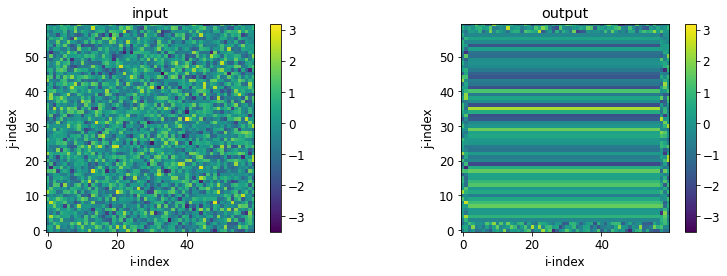

In [7]:
# run stencil i-1
# TODO: add stencil call here
# visualize results
# TODO: add visualization here

# run stencil i-1
shift_i_minus_one(a=out_field_i_minus, origin=origin, domain=domain)
# visualize results
plot_two_ij_slices(in_field, out_field_i_minus)

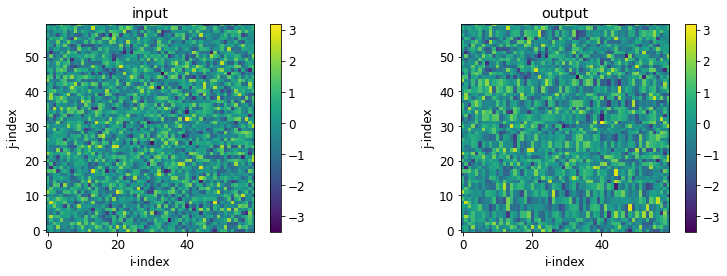

In [8]:
# run stencil j+1
# TODO: add stencil call here
# visualize results
# TODO: add visualization here

# run stencil j+1
shift_j_plus_one(a=out_field_j, origin=origin, domain=domain)
# visualize results
plot_two_ij_slices(in_field, out_field_j)

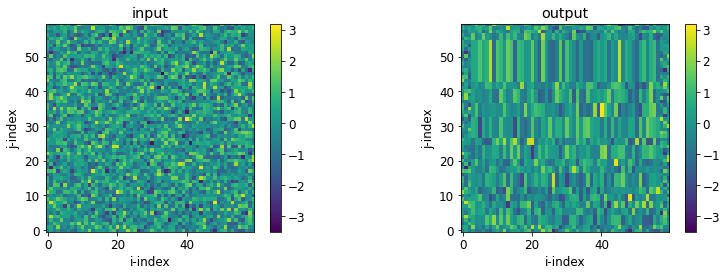

In [9]:
# run stencil j-1
# TODO: add stencil call here
# visualize results
# TODO: add visualization here

# run stencil j-1
shift_j_minus_one(a=out_field_j_minus, origin=origin, domain=domain)
# visualize results
plot_two_ij_slices(in_field, out_field_j_minus)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: Discuss what these results tell you</b><br>
    <ol>
        <li style="margin-bottom: 10px">How are the loops traversed?</li>
        <li style="margin-bottom: 10px">Is there blocking?</li>
        <li style="margin-bottom: 10px">Are the horizontal dimensions treated differently?</li>
        <li style="margin-bottom: 10px">Is it clear why the example is illegal?</li>
        <li style="margin-bottom: 10px"> (optional:) Compare your results to the other backend.</li>
    </ol>
</div>

## Compute Extents
In the previous section we've seen that we have the option to manually set the compute extent of stencils. This is required if we split stencils. Merged stencils have a way of automatically deducing the maximal extent in which computation needs to happen. We try to illustrate how automatic exentison of the compute domain happens

In [10]:
backend = "numpy"
@gtscript.stencil(backend=backend)
def set_const(output_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        output_field = 10
@gtscript.stencil(backend=backend)
def read_off_center(input_field: Field[np.float64], output_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        output_field = input_field[1, 0, 0]

In [11]:
@gtscript.stencil(backend=backend)
def set_const_and_read(input_field: Field[np.float64], output_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        input_field = 10
        output_field = input_field[1, 0, 0]

In [12]:
# domain setup
nhalo = 3
nx, ny, nz = 4, 4, 1

origin = (nhalo, nhalo, 0)
domain = (nx, ny, nz)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)

# storage creation
const_field_1 = gt4py.storage.from_array(np.zeros((shape[0], shape[1], shape[2]), dtype=float), backend, origin, shape, dtype=np.float64)
const_field_2 = const_field_1.copy()
out_field_1 = const_field_1.copy()
out_field_2 = const_field_1.copy()


# call the two individual stencils
set_const(output_field=const_field_1, origin=origin,domain=domain)
read_off_center(input_field=const_field_1, output_field=out_field_1, origin=origin, domain=domain)

# call the merged stencil
set_const_and_read(input_field=const_field_2, output_field=out_field_2, origin=origin, domain=domain)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Make a guess what the result of the two stencils will look like.</li>
        <li style="margin-bottom: 10px"> Verify your guess by plotting the output fields.</li>
    </ol>
</div>

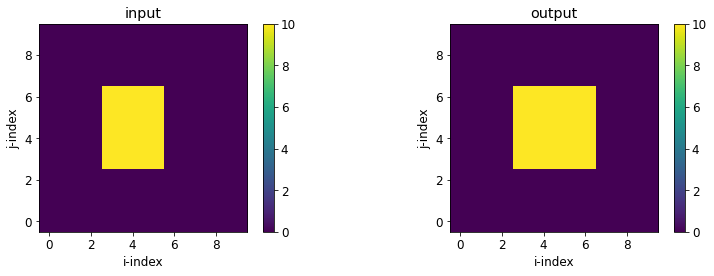

In [13]:
# plot the two output fields
plot_two_ij_slices(out_field_1, out_field_2)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Adapt the first example to ensure the results are the same.</li>
    </ol>
</div>

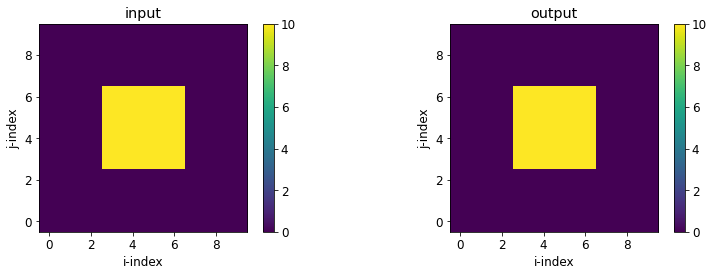

In [14]:
origin_shifted = (nhalo-1, nhalo-1, 0)
domain_extended = (nx+2, ny+2, nz)

# call the two individual stencils
set_const(output_field=const_field_1, origin=origin_shifted,domain=domain_extended)
read_off_center(input_field=const_field_1, output_field=out_field_1, origin=origin, domain=domain)

# call the merged stencil
set_const_and_read(input_field=const_field_2, output_field=out_field_2, origin=origin, domain=domain)

plot_two_ij_slices(out_field_1, out_field_2)

## Stencil Program

The previous notebook introduced the horizontal Laplacian as an example stencil. A Laplacian is sometimes used as a numerical filter, but has the downside of not being very scale selective. Because of this, some models choose to implement higher order filters (e.g. [Xue 2000, Monthly Weather Review](http://twister.ou.edu/papers/Xue2000Diffusion.pdf)).

\begin{eqnarray}
\frac{\partial \phi}{\partial t} = S + (-1)^{n/2+1} \alpha_n \nabla^n \phi \\
\end{eqnarray}

where $S$ represents all other processes, $n$ is the order of the filter, and $\alpha_n$ is the filter constant. Let's assume $S=0$ and take a closer look at the 2nd-order filter (n=2)

\begin{eqnarray}
\frac{\partial \phi}{\partial t} & = & + \alpha_2 \nabla^2 \phi \\
& = & + \alpha_2 \Delta \phi \\[2ex]
\end{eqnarray}

and the 4th-order filter (n=4)

\begin{eqnarray}
\frac{\partial \phi}{\partial t} & = & - \alpha_4 \nabla^4 \phi \\
& = & - \alpha_4 \Delta \left( \Delta \phi \right) \\
\end{eqnarray}

where $\alpha_2$ and $\alpha_4$ are the diffusion coefficients. This corresponds to a double application of a simple horizontal Laplacian where we choose the coefficient correspondingly. So we can potentially re-use the stencil we have already coded in the previous session, which is reproduced below for convenience, but using a different initialization of the input field.

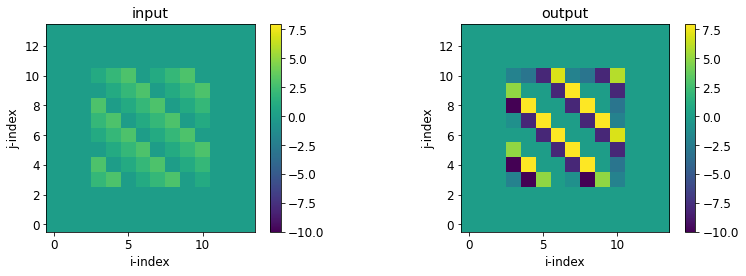

In [15]:
# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def laplacian(in_field: Field[np.float64], out_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        out_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)

# apply stencil
laplacian(in_field=in_field, out_field=out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))

# visualize results
plot_two_ij_slices(in_field, out_field)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    We are going to extend the above program to a full stencil program applying multiple iterations of the 4th-order numerical diffusion filter to an input field using an Euler forward step.
    <ol>
        <li style="margin-bottom: 10px"> Implement a second stencil <code>euler_step(in_field, out_field, alpha)</code> which computes the time update $\mathrm{out\_field} = \mathrm{in\_field} + \alpha \,\, \mathrm{out\_field}$.</li>
        <li style="margin-bottom: 10px"> Implement a timeloop which does 20 iterations of calling <code>laplacian(in_field, out_field)</code>, <code>euler_step(in_field, out_field, alpha)</code> and a finally does a timeswap using <code>in_field[:] = out_field[:]</code> at the end of each iteration.</li>
        <li style="margin-bottom: 10px"> Run the program and check your results by visually inspection. Note that if $\alpha_2 > 1/8$ you filter will be unstable.</li>
        <li style="margin-bottom: 10px"> Imlement a 4th-order filter by calling the <code>laplacian</code> stencil twice. It is easiest to create an additional storage <code>tmp_field</code> to carry the intermediate result from the first invocation to the second. Make sure you adapt the <code>origin</code> and <code>domain</code> for the first invocation of <code>laplacian</code> to compute on an extended domain. Also, don't forget to flip the sign in front of the diffusion coefficient in <code>euler_step</code>.</li>
        <li style="margin-bottom: 10px"> Run you program and check your results by visually inspection. Note that if $\alpha_4 > 1/32$ you filter will be unstable.</li>
    </ol>
</div>

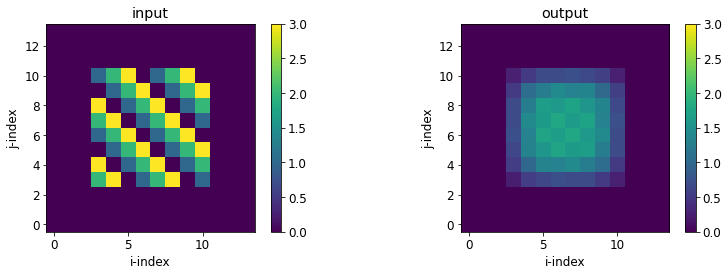

In [16]:
# REMOVE - Solution

# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def laplacian(in_field: Field[np.float64], out_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        out_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        
@gtscript.stencil(backend=backend)
def euler_step(in_field: Field[np.float64], out_field: Field[np.float64], *, alpha: np.float64):
    with computation(PARALLEL), interval(...):
        out_field = in_field - alpha * out_field
        
@gtscript.stencil(backend=backend)
def time_swap(in_field: Field[np.float64], out_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        in_field = out_field
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
orig_field = in_field.copy()
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
tmp_field = out_field.copy()

# apply stencil
alpha = 1./32.
for n in range(20):
    laplacian(in_field=in_field, out_field=tmp_field, origin=(nhalo-1, nhalo-1, 0), domain=(nx+2, ny+2, nz))
    laplacian(in_field=tmp_field, out_field=out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))
    euler_step(in_field=in_field, out_field=out_field, alpha=alpha, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))
    time_swap(in_field=in_field, out_field=out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))


# visualize results
plot_two_ij_slices(orig_field, out_field)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Copy the above program into a cell below. Replace the two stencils <code>laplacian</code> and <code>euler_step</code> with a single stencil <code>numerical_filter(in_field, tmp_field, out_field, alpha)</code> which implements the two laplacians, the Euler forward integration as well as the time swap as individual stages.</li>
        <li style="margin-bottom: 10px"> Check your results against the reference above.</li>
    </ol>
</div>

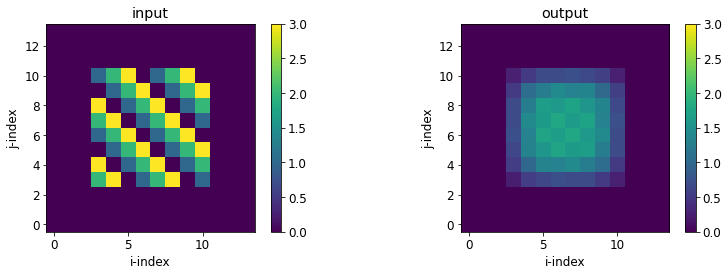

In [17]:
# REMOVE - Solution

# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def numerical_filter(in_field: Field[np.float64], tmp_field: Field[np.float64], out_field: Field[np.float64], *, alpha: np.float64):
    with computation(PARALLEL), interval(...):
        tmp_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])
        out_field = in_field - alpha * out_field
    with computation(PARALLEL), interval(...):
        in_field = out_field
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
orig_field = in_field.copy()
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
tmp_field = out_field.copy()

# apply stencil
alpha = 1./32.
for n in range(20):
    numerical_filter(in_field=in_field, tmp_field=tmp_field, out_field=out_field, alpha=alpha, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))

# visualize results
plot_two_ij_slices(orig_field, out_field)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    The temporary field is not required output. You can adapt the stencil to not require it as an argument
    <ol>
        <li style="margin-bottom: 10px"> Implement a second version of <code>numerical_filter(in_field, out_field, alpha)</code> that allocates the temporary varibale on the fly.</li>
        <li style="margin-bottom: 10px">  Run the program and check your results by visually inspection. Note that if $\alpha_2 > 1/32$ you filter will be unstable</li>
    </ol>
</div>

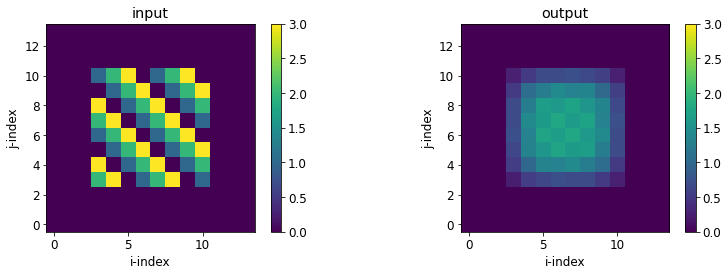

In [18]:
# REMOVE - Solution

# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def numerical_filter(in_field: Field[np.float64], out_field: Field[np.float64], *, alpha: np.float64):
    with computation(PARALLEL), interval(...):
        tmp_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])
        out_field = in_field - alpha * out_field
    with computation(PARALLEL), interval(...):
        in_field = out_field
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
orig_field = in_field.copy()
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)

# apply stencil
alpha = 1./32.
for n in range(20):
    numerical_filter(in_field=in_field, out_field=out_field, alpha=alpha, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))
    in_field[:] = out_field[:]

# visualize results
plot_two_ij_slices(orig_field, out_field)

## Timing temporary variables

As the next part of this exercise we want to investigate how temporaries affect performance of the code. Compare the solutions of `numerical_filter` with and without temporaries to see how they perform

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Use the definition of the two versions of the numerical filter from the exercise above to check the performance difference </li>
        <li style="margin-bottom: 10px"> What do the results tell us?</li>
        <li style="margin-bottom: 10px"> Try how other backends perform </li>
    </ol>
</div>

In [19]:
import timeit

In [20]:
# define stencil with temporary
#def numerical_filter_with(in_field: Field[float], out_field: Field[float], tmp_field:Field[np.float64], alpha: np.float64 ):
    #TODO:
# define stencil with temporary
#def numerical_filter_without(in_field: Field[float], out_field: Field[float], alpha: np.float64):
    #TODO:

# define stencil with temporary
def numerical_filter_with(in_field: Field[float], out_field: Field[float], tmp_field:Field[np.float64], alpha: np.float64 ):
    with computation(PARALLEL), interval(...):
        tmp_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])
        out_field = in_field - alpha * out_field
    with computation(PARALLEL), interval(...):
        in_field = out_field
# define stencil with temporary
def numerical_filter_without(in_field: Field[float], out_field: Field[float], alpha: np.float64):
    with computation(PARALLEL), interval(...):
        tmp_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])
        out_field = in_field - alpha * out_field
    with computation(PARALLEL), interval(...):
        in_field = out_field

In [21]:
#def run_experiment_with(backend, size):
#    # domain setup
#    nx = 100*(size+1)
#    nz = 79
#    halo = 3
#    shape = (nx + 2 * halo, nx + 2 * halo, nz)
#    
#    # input setup
#    # TODO: create the required fields
#    
#    # stencil setup
#    # TODO: compile your filter
#    
#    # computation
#    tic = timeit.default_timer()
#    for i in range(20):
#        # TODO: call your filter here
#    toc = timeit.default_timer()
#    return toc - tic

def run_experiment_with(backend, size):
    # domain setup
    nx = 100*(size+1)
    nz = 79
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, nz)
    
    # input setup
    in_field = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend=backend,
    )
    for k in range(nz):
        for j in range(nhalo, ny + nhalo):
            for i in range(nhalo, nx + nhalo):
                in_field[i, j, k] = (i + j + k) % 4        
    out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
    tmp_field = out_field.copy()
    alpha = 1./32.
    
    # stencil setup
    numerical_filter = gtscript.stencil(backend, numerical_filter_with)
    # computation
    tic = timeit.default_timer()
    for i in range(20):
        numerical_filter(in_field, out_field, tmp_field, alpha, origin=(halo, halo, 0), domain=(nx, nx, nz))
    toc = timeit.default_timer()
    return toc - tic

In [22]:
#def run_experiment_without(backend, size):
#    # TODO: set up the same experiment using the stencil without the temporary field allocated
#    return total time
    
def run_experiment_without(backend, size):
    # domain setup
    nx = 100*(size+1)
    nz = 79
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, nz)
    
    # input setup
    in_field = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend=backend,
    )
    for k in range(nz):
        for j in range(nhalo, ny + nhalo):
            for i in range(nhalo, nx + nhalo):
                in_field[i, j, k] = (i + j + k) % 4        
    out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
    alpha = 1./32.
    
    # stencil setup
    numerical_filter = gtscript.stencil(backend, numerical_filter_without)
    # computation
    tic = timeit.default_timer()
    for i in range(20):
        numerical_filter(in_field, out_field, alpha, origin=(halo, halo, 0), domain=(nx, nx, nz))
    toc = timeit.default_timer()
    return toc - tic

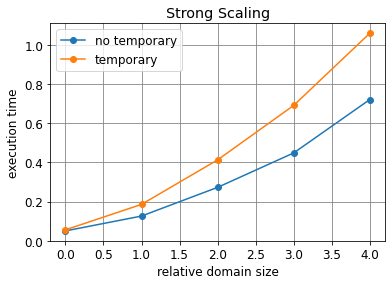

In [23]:
temp_times = np.zeros(5)
no_temp_times = np.zeros(5)

for j in range(5):
    no_temp_times[j] = run_experiment_without("gtx86", j)
    temp_times[j] = run_experiment_with("gtx86", j)

#plotting the results
plt.plot(range(5), no_temp_times, "-o", label="no temporary")
plt.plot(range(5), temp_times, "-o", label="temporary")
plt.title("Strong Scaling")
plt.grid(color="gray", linestyle='-')
plt.legend()
plt.xlabel("relative domain size")
plt.ylabel("execution time")

plt.show()

## Generate Scalability Data

Here we define the `origin`, `domain`, data `shape`, and `backends`. The `gtx86` backend is replaced with `gtcuda` to generate CUDA code. The inner loop executes the stencil `nruns` times for each backend, with the horizontal domain size doubled at each iteration to generate scalability timings.

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    (Hint: Make sure that when you modify code you retain the original code by commenting it out so that you undo any of the modifications you do.)
    <ol>
        <li style="margin-bottom: 10px"> Run the scalabiliy experiments outlined below on the laplacian stencil</li>
        <li style="margin-bottom: 10px"> Analyze the plot</li>
    </ol>
</div>

In [24]:
def laplacian_def(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

In [25]:
ni, nj, nk = 24, 24, 80
nhalo = 3

In [26]:
def run_laplacian_scaling(stencil_def, backends, domain, origin, nruns = 5, factor = 2, dtype=np.float64):
    ni, nj, nk = domain
    init_ni = ni
    init_nj = nj

    timings = dict()
    sizes = dict()
    
    for backend in backends:
        ni = init_ni
        nj = init_nj

        sizes[backend] = []
        timings[backend] = []

        for n in range(0, nruns):
            print(f"Running with {backend} backend ({n})...")

            domain = (ni, nj, nk)
            shape = (ni + 2 * nhalo, nj + 2 * nhalo, nk)

            rand_data = np.random.randn(*shape)        
            in_field = gt4py.storage.from_array(rand_data, backend, origin, shape, dtype=dtype)        
            out_field = gt4py.storage.zeros(backend, origin, shape, dtype)        
            exec_info = {}

            stencil = gtscript.stencil(backend, stencil_def)
            stencil(in_field, out_field, coeff=0.125, origin=origin, domain=domain, exec_info=exec_info)  # , validate_args=False)

            call_time = (exec_info['call_end_time'] - exec_info['call_start_time']) * 1000.
            run_time = (exec_info['run_end_time'] - exec_info['run_start_time']) * 1000.        

            timings[backend].append(run_time)
            sizes[backend].append(ni)

            ni *= factor
            nj *= factor
            
    return timings, sizes
            
timings, sizes = run_laplacian_scaling(
    laplacian_def, ["numpy", "gtmc", "gtx86"], (ni, nj, nk), (nhalo, nhalo, 0)
)

Running with numpy backend (0)...
Running with numpy backend (1)...
Running with numpy backend (2)...
Running with numpy backend (3)...
Running with numpy backend (4)...
Running with gtmc backend (0)...
Running with gtmc backend (1)...
Running with gtmc backend (2)...
Running with gtmc backend (3)...
Running with gtmc backend (4)...
Running with gtx86 backend (0)...
Running with gtx86 backend (1)...
Running with gtx86 backend (2)...
Running with gtx86 backend (3)...
Running with gtx86 backend (4)...


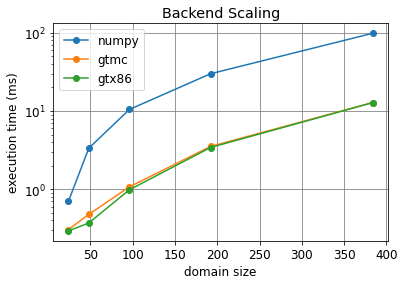

In [27]:
def plot_scaling_data(timings, sizes):    
    for backend in timings.keys():
        plt.plot(sizes[backend], timings[backend], "-o", label=backend)
    
    plt.title("Backend Scaling")
    plt.grid(color="gray", linestyle='-')
    plt.legend()
    plt.xlabel("domain size")
    plt.ylabel("execution time (ms)")
    plt.yscale("log")
    plt.show()
    
plot_scaling_data(timings, sizes)

## Storage Layouts

GT4Py optimizes performance not only with the code it generates, but also with the way it structures data for the target backend.

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> By analyzing the strides of the different backends, can you see in what order the loops are generated?</li>
    </ol>
</div>

In [28]:
numpy_field = gt4py.storage.zeros("numpy", (0, 0, 0), (64, 64, 64), np.float)
print("numpy type: ", type(numpy_field))
print("numpy strides: ", numpy_field.strides)

gtmc_field = gt4py.storage.zeros("gtmc", (0, 0, 0), (64, 64, 64), np.float)
print("gtmc type: ", type(gtmc_field))
print("gtmc strides: ", gtmc_field.strides)

gtx86_field = gt4py.storage.zeros("gtx86", (0, 0, 0), (64, 64, 64), np.float)
print("gtx86 type: ", type(gtx86_field))
print("gtx86 strides: ", gtx86_field.strides)

numpy type:  <class 'gt4py.storage.storage.CPUStorage'>
numpy strides:  (32768, 512, 8)
gtmc type:  <class 'gt4py.storage.storage.CPUStorage'>
gtmc strides:  (8, 32768, 512)
gtx86 type:  <class 'gt4py.storage.storage.CPUStorage'>
gtx86 strides:  (32768, 512, 8)
